In [85]:
# importing modules.
import torch
import torch.nn.functional as F
import numpy as np
from torch import nn, optim
from torchvision import transforms, datasets

In [86]:
# Check if GPU avaliable
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [87]:
# defining transforms for images.
transform = transforms.Compose([transforms.ToTensor()])

In [88]:
# Loading data from dataset

# Training Data
train_data = datasets.FashionMNIST('fashion_data', train=True, download=True, transform=transform)

#Testing Data
test_data = datasets.FashionMNIST('fashion_data', train=False, download=True, transform=transform)

In [89]:
# Spliting train data index into train and validation
num_train = len(train_data)
idxs = list(range(num_train))
np.random.shuffle(idxs)

# using 20% of train data for validation.
split = int(np.floor(0.2 * num_train))
train_idx = idxs[split:]
valid_idx = idxs[:split]

In [90]:
# samplers to obtain indices for batches.
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

In [91]:
# defining loader to load data in batches.
# defining batch size
batch_size = 20

# Training loader
train_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Validation loader
valid_loader = torch.utils.data.DataLoader(train_data, sampler=valid_sampler, batch_size=batch_size)

# testing loader
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

classes = ['T-shirt/top',
            'Trouser',
            'Pullover',
            'Dress',
            'Coat',
            'Sandal',
            'Shirt',
            'Sneaker',
            'Bag',
            'Ankle Boot']

In [92]:
# Now let's see the data we loaded visually.
# import matplot library
%matplotlib inline
import matplotlib.pyplot as plt

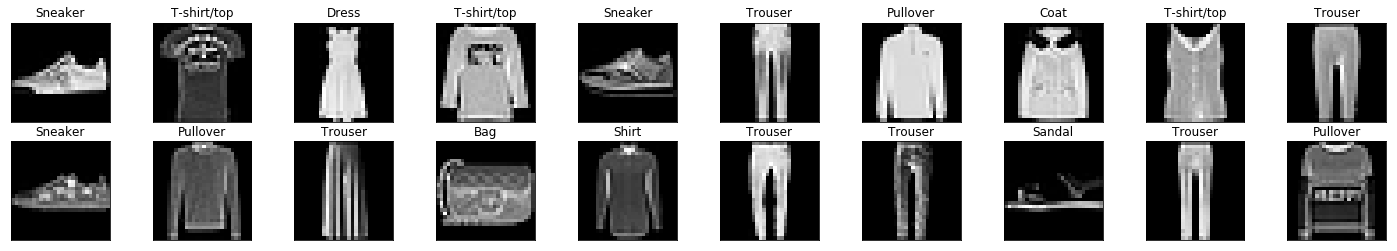

In [93]:
# taking one batch from train_loader 
images, labels = iter(train_loader).next()

# converting images from tensor to numpy array just for visulization. 
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for i in range(20):
    ax = fig.add_subplot(2, 20/2, i + 1, xticks=[], yticks=[])
    ax.set_title(classes[labels[i].item()])
    ax.imshow(np.squeeze(images[i]), cmap='gray')

In [94]:
# Defining network architecture.
class Network(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        # convolutional layer (sees 28 x 28 x 1 image tensor)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        
        # convolutional layer (sees 14 x 14 x 16 image tensor)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        
        # Hidden layer: 32 * 7 * 7 => 128.
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        
        # Hidden layer 1: 128 => 128.
        self.fc2 = nn.Linear(128, 128)
        
        # Hidden Layer 2: 128 => 10.
        self.fc3 = nn.Linear(128, 10)
        
        # Defining dropout with p = 0.2
        self.dropout = nn.Dropout(p=0.2)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
    def forward(self, X):
        # Convolutional Layer and  max pooling layers.
        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool(F.relu(self.conv2(X)))
        
        # Flatten inputs.
        X = X.view(-1, 32 * 7 * 7)
        
        # Input Layer.
        X = self.dropout(F.relu(self.fc1(X)))
        
        # Hidden Layer 1
        X = self.dropout(F.relu(self.fc2(X)))
        
        # Hidden Layer 2
        X = self.fc3(X)
        
        return X
        
        

In [95]:
model = Network()
model

Network(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [0]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [0]:
model = model.to(device)

In [14]:
# training model
# Epochs for training.
epochs = 30

# defining min_valid loss to np.inf
valid_min = np.inf

for i in range(epochs):
    
    # set model for training.
    model.train()
    
    # defining train loss and validation loss to 0.0 later we calculate using loss function.
    train_loss = 0.0
    valid_loss = 0.0
    
    for images, labels in train_loader:
        
        images, labels = images.to(device), labels.to(device)
        
        # cleaning gradient for all optimized variables.
        optimizer.zero_grad()
        
        # forwardpass passing images to model
        output = model(images)
        
        # Calculating loss to perform backward pass
        loss = criterion(output, labels)
        
        # backward pass compute loss with resp to parameters.
        loss.backward()
        
        # optimizer single step.
        optimizer.step()
        
        # updating total loss
        train_loss += loss.item() * images.size(0)
        
    # set model for evalutaion.
    model.eval()
    
    # validating model.
    for images, labels in valid_loader:
        
        images, labels = images.to(device), labels.to(device)
        
        # forwardpass passing images to model
        output = model(images)
        
        # Calculating loss to perform backward pass
        loss = criterion(output, labels)
        
        # Updating total validation loss.
        valid_loss += loss.item() * images.size(0)
        
    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)
    
    print("Training loss:", train_loss, "\tValidation loss:", valid_loss, "\tEpoch:", str(i+1))
    
    if valid_loss <= valid_min:
        print("Saving model.")
        torch.save(model.state_dict(), 'model_cnn_fashion.pth')
        valid_min = valid_loss

Training loss: 0.4901276991590858 	Validation loss: 0.08550871389607588 	Epoch: 1
Saving model.
Training loss: 0.40406545642018316 	Validation loss: 0.08231891923770308 	Epoch: 2
Saving model.
Training loss: 0.38867940520060557 	Validation loss: 0.08062218564500412 	Epoch: 3
Saving model.
Training loss: 0.391960832203428 	Validation loss: 0.08090992246816556 	Epoch: 4
Training loss: 0.3867010677618285 	Validation loss: 0.07825635095934073 	Epoch: 5
Saving model.
Training loss: 0.38609421854776643 	Validation loss: 0.087129010848701 	Epoch: 6
Training loss: 0.387888694545875 	Validation loss: 0.07992119517984489 	Epoch: 7
Training loss: 0.379765573511521 	Validation loss: 0.09091916197662553 	Epoch: 8
Training loss: 0.38425163124874234 	Validation loss: 0.07888553826759259 	Epoch: 9
Training loss: 0.38939030763693155 	Validation loss: 0.07838208731636405 	Epoch: 10
Training loss: 0.3820509851239622 	Validation loss: 0.07864139056702454 	Epoch: 11
Training loss: 0.38218340813368556 	Vali

In [100]:
model.load_state_dict(torch.load('model_cnn_fashion.pth', map_location=device))
model

Network(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [101]:
# Testing Model.
# Initilizing list to moniter test and accuracy.
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# prepate mode for evalution.
model.eval()

for images, labels in test_loader:
    
    images, labels = images.to(device), labels.to(device)
    
    # forwardpass passing images to model
    output = model(images)
    
    # calculate the loss
    loss = criterion(output, labels)
    
    # update test loss 
    test_loss += loss.item() * images.size(0)
    
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    
    # compare predictions to true label
    correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
    
     # calculate test accuracy for each object class
    for i in range(batch_size):
        
        label = labels.data[i]
        
        class_correct[label] += correct[i].item()
        
        class_total[label] += 1
        
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: \t %2d%% (%2d/%2d)' % (
            str(classes[i]), 100 * class_correct[i]/ class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: -0.003471

Test Accuracy of T-shirt/top: 	 83% (833/1000)
Test Accuracy of Trouser: 	 95% (957/1000)
Test Accuracy of Pullover: 	 83% (833/1000)
Test Accuracy of Dress: 	 93% (938/1000)
Test Accuracy of  Coat: 	 65% (657/1000)
Test Accuracy of Sandal: 	 95% (951/1000)
Test Accuracy of Shirt: 	 50% (509/1000)
Test Accuracy of Sneaker: 	 96% (967/1000)
Test Accuracy of   Bag: 	 95% (954/1000)
Test Accuracy of Ankle Boot: 	 94% (945/1000)

Test Accuracy (Overall): 85% (8544/10000)


In [102]:
# Visualize data with test result.
# obtain one batch of test images
dataiter = iter(test_loader)

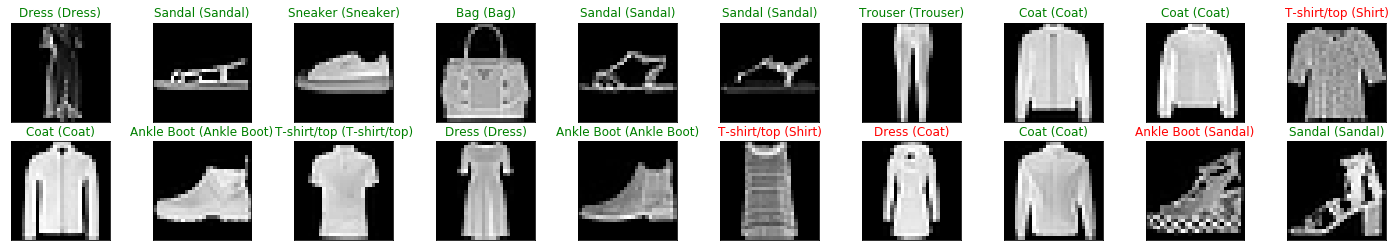

In [103]:
images, labels = dataiter.next()

images = images.to(device)

labels = labels.to(device)

# get sample outputs
output = model(images)

# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# prep images for display
images = images.cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])),
                 color=("green" if preds[idx]==labels[idx] else "red"))